In [1]:
%matplotlib inline

In [118]:
import tensorflow as tf
import tensorflow.contrib.slim as slim
from scipy.io import loadmat
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import os
import itertools
import math
from ipywidgets import interact, interactive, fixed
import ipywidgets as widgets

In [3]:
i = mpimg.imread('Dataset/CRCHistoPhenotypes_2016_04_28/Classification/img1/img1.bmp')

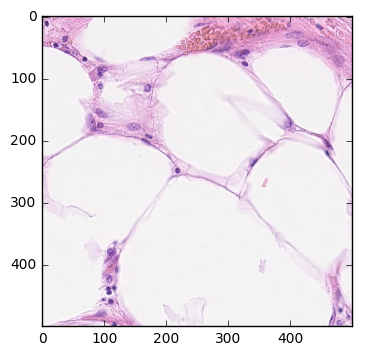

In [4]:
plt.imshow(i)

In [5]:
d = loadmat('Dataset/CRCHistoPhenotypes_2016_04_28/Classification/img1/img1_fibroblast.mat')['detection']

In [6]:
d

array([[ 148.78269485,  181.47754293],
       [  96.60303831,  159.68097754],
       [  79.42998679,  172.89101717],
       [ 171.9002642 ,   71.834214  ],
       [  95.77741083,  116.08784676],
       [ 410.34147952,   33.19484808],
       [ 419.91875826,   46.73513871],
       [ 172.89101717,  197.16446499],
       [ 168.2675033 ,  204.42998679],
       [ 110.96895641,  383.42602378],
       [ 108.65719947,  424.70739762]])

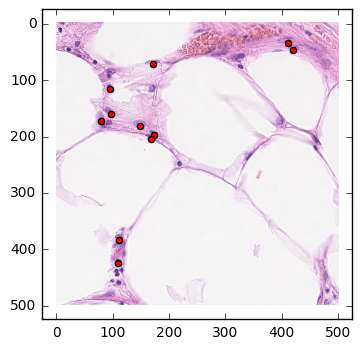

In [7]:
plt.imshow(i)
plt.scatter(d[:,0], d[:,1], c='r')

In [8]:
os.path.splitext("Dataset/CRCHistoPhenotypes_2016_04_28/whatever.bmp")

('Dataset/CRCHistoPhenotypes_2016_04_28/whatever', '.bmp')

In [9]:
categories = [
    'epithelial',
    'fibroblast',
    'inflammatory',
    'others',
]

In [10]:
def get_image_data(filename, categories):
    img = mpimg.imread(filename)
    (name, ext) = os.path.splitext(filename)
    n = len(categories)
    centres = []
    labels = []
    for (i, c) in enumerate(categories):
        d = loadmat(name + ('_%s.mat' % c))['detection']
        centres.append(d)
        one_hot_row = np.zeros((n,), dtype='int')
        one_hot_row[i] = 1
        labels.append(np.tile(one_hot_row, (d.shape[0], 1)))
    centres = np.vstack(centres)
    labels = np.vstack(labels)
    return (img, centres, labels)

In [11]:
(img, centres, labels) = get_image_data('Dataset/CRCHistoPhenotypes_2016_04_28/Classification/img1/img1.bmp', categories)

In [12]:
np.hstack((centres, labels)).astype('int32')

array([[148, 181,   0,   1,   0,   0],
       [ 96, 159,   0,   1,   0,   0],
       [ 79, 172,   0,   1,   0,   0],
       [171,  71,   0,   1,   0,   0],
       [ 95, 116,   0,   1,   0,   0],
       [410,  33,   0,   1,   0,   0],
       [419,  46,   0,   1,   0,   0],
       [172, 197,   0,   1,   0,   0],
       [168, 204,   0,   1,   0,   0],
       [110, 383,   0,   1,   0,   0],
       [108, 424,   0,   1,   0,   0],
       [  8,  15,   0,   0,   1,   0],
       [ 38,  39,   0,   0,   1,   0],
       [ 22,  50,   0,   0,   1,   0],
       [ 69,  72,   0,   0,   1,   0],
       [328,  60,   0,   0,   1,   0],
       [327,  79,   0,   0,   1,   0],
       [108, 446,   0,   0,   1,   0],
       [219, 251,   0,   0,   0,   1],
       [111, 462,   0,   0,   0,   1]], dtype=int32)

In [13]:
def draw(img, centres, labels, categories, figsize=(10,10)):
    colours = ['red', 'blue', 'green', 'yellow', 'white']
    plt.figure(figsize=figsize)
    plt.imshow(img)
    for (i, category) in enumerate(categories):
        x = centres[labels[:,i] == 1, 0]
        y = centres[labels[:,i] == 1, 1]
        colour = colours[i % len(colours)]
        plt.scatter(x, y, c=colour, label=category)
    plt.legend(loc='center left', bbox_to_anchor=(1,0.5), scatterpoints=1)

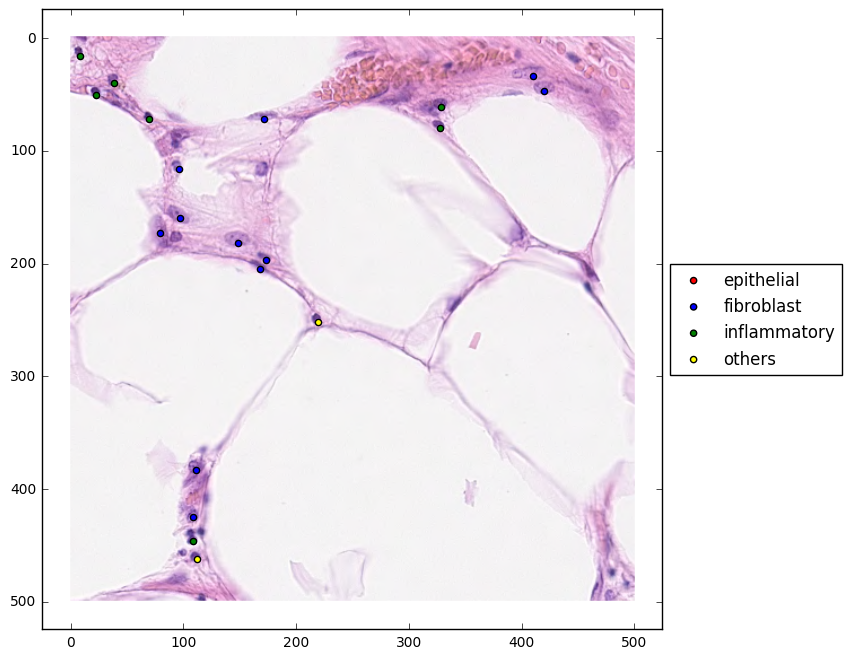

In [14]:
draw(img, centres, labels, categories, figsize=(8,8))

In [15]:
def get_dataset(num_images, categories):
    all_img = []
    all_centres = []
    all_labels = []
    for i in range(1,num_images+1):
        path = 'Dataset/CRCHistoPhenotypes_2016_04_28/Classification/img%d/img%d.bmp' % (i, i)
        (img, centres, labels) = get_image_data(path, categories)
        all_img.append(img)
        all_centres.append(centres)
        all_labels.append(labels)
    return (all_img, all_centres, all_labels)

In [16]:
(i, c, L) = get_dataset(100, categories)

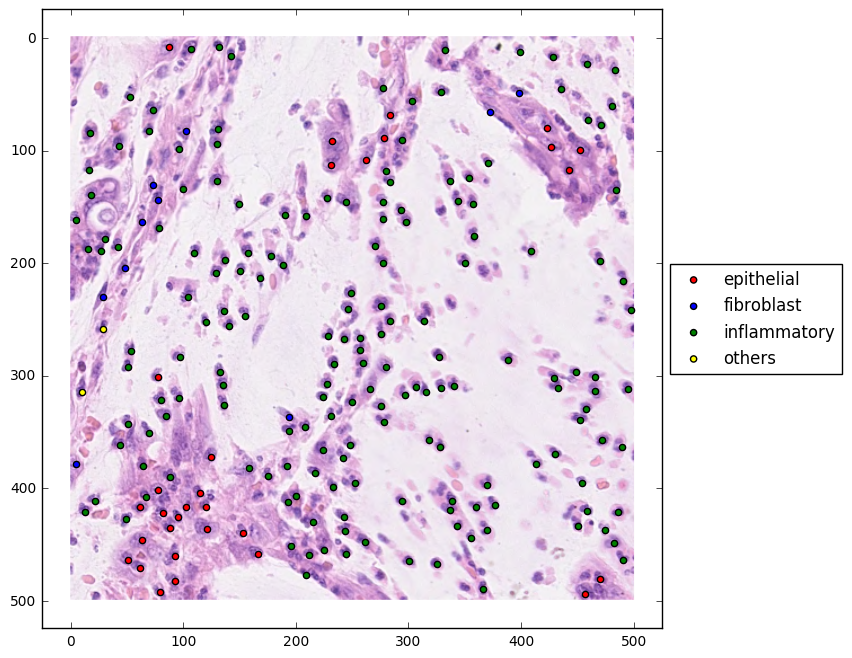

In [17]:
n = 5
draw(i[n], c[n], L[n], categories, figsize=(8,8))

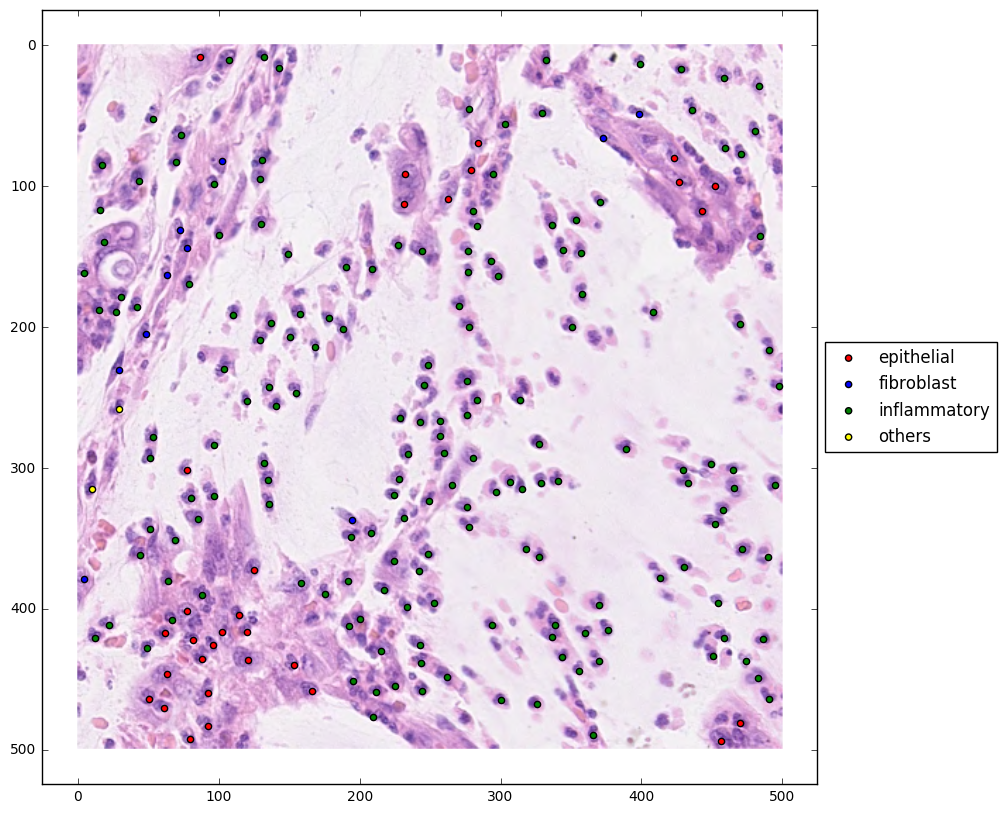

In [18]:
(img, centres, labels) = get_image_data('Dataset/CRCHistoPhenotypes_2016_04_28/Classification/img6/img6.bmp', categories)
draw(img, centres, labels, categories)

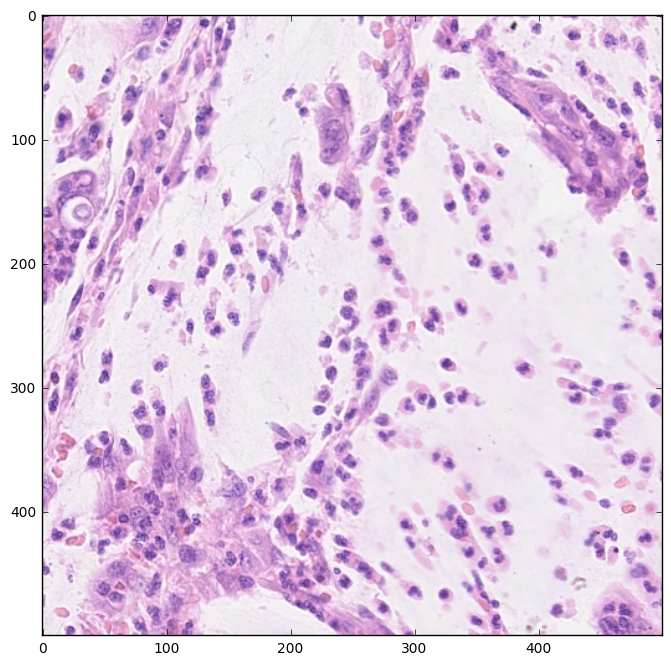

In [19]:
plt.figure(figsize=(8,8))
plt.imshow(img)

In [20]:
def get_examples(all_img, all_centres, all_labels, H, W):
    patches = []
    output_labels = []
    output_centres = []
    output_img_ids = []
    cnt_dropped = 0
    assert H%2==1
    assert W%2==1
    dx = (W-1)/2
    dy = (H-1)/2
    for (i, (img, centres, labels)) in enumerate(zip(all_img, all_centres, all_labels)):
        (imgH, imgW, _) = img.shape
        for ((x, y), label) in zip(centres, labels):
            x = int(x)
            y = int(y)
            if (x - dx < 0 or
                x + dx >= imgW or
                y - dy < 0 or
                y + dy >= imgH):
                cnt_dropped += 1
                continue
            patches.append(img[y-dy:y+dy+1, x-dx:x+dx+1, :])
            output_labels.append(label)
            output_centres.append([x, y])
            output_img_ids.append(i)
    patches = np.stack(patches)
    output_labels = np.stack(output_labels)
    output_centres = np.array(output_centres)
    output_img_ids = np.array(output_img_ids)
    print "Dropped %d patches because too close to image border" % cnt_dropped
    return (patches, output_labels, output_centres, output_img_ids)

In [21]:
(patches, labels, centres, img_ids) = get_examples(i, c, L, 27, 27)

Dropped 2082 patches because too close to image border


In [22]:
patches.shape, labels.shape, centres.shape, img_ids.shape

((20362, 27, 27, 3), (20362, 4), (20362, 2), (20362,))

[0 1 0 0]
[148 181]
0


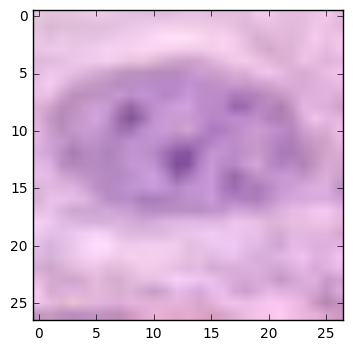

In [23]:
plt.imshow(patches[0])
print labels[0]
print centres[0]
print img_ids[0]

True


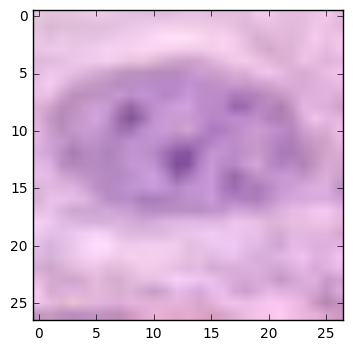

In [24]:
test_index = 0
(x, y) = centres[test_index]
plt.imshow(i[img_ids[test_index]][y-13:y+14,x-13:x+14,:])
print np.all(i[img_ids[test_index]][y-13:y+14,x-13:x+14,:] == patches[test_index])

In [25]:
patches.shape, labels.shape, centres.shape, img_ids.shape

N = patches.shape[0]
np.random.seed(0) # predictable shuffling for now
perm = np.random.permutation(N)
patches_shuffled = patches[perm]
labels_shuffled = labels[perm]
centres_shuffled = centres[perm]
img_ids_shuffled = img_ids[perm]

num_train = int(0.8 * N)
train_patches = patches_shuffled[:num_train]
train_labels = labels_shuffled[:num_train]
train_centres = centres_shuffled[:num_train]
train_img_ids = img_ids_shuffled[:num_train]

test_patches = patches_shuffled[num_train:]
test_labels = labels_shuffled[num_train:]
test_centres = centres_shuffled[num_train:]
test_img_ids = img_ids_shuffled[num_train:]

In [26]:
train_patches.shape, train_labels.shape, test_patches.shape, test_labels.shape

((16289, 27, 27, 3), (16289, 4), (4073, 27, 27, 3), (4073, 4))

inflammatory


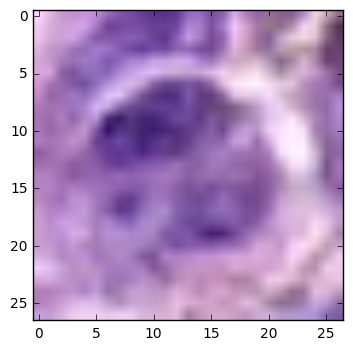

In [27]:
plt.imshow(train_patches[0])
print categories[np.argmax(train_labels[0])]

In [28]:
np.sum(train_labels, axis=0)

array([5683, 4074, 5043, 1489])

In [60]:
#how_many_times = 0

In [256]:
def choose_aug(img, centre, H, W):
    #global how_many_times
    # Do a bunch of work to figure out which deltas are allowed at this position
    assert H%2==1
    assert W%2==1
    halfH = (W-1)/2
    halfW = (H-1)/2
    (imgH, imgW, _) = img.shape
    (x, y) = centre

    # Helper function to check for out of bounds
    def inbounds(dx, dy):
        return (x + dx - halfW >= 0 and
                x + dx + halfW < imgW and
                y + dy - halfH >= 0 and
                y + dy + halfH < imgH)
    
    # Iterate over each neighbour position
    deltas = []
    d = 3 # Parameter, should ultimately be factored out
    for dx in range(-d, d+1):
        for dy in range(-d, d+1):
            if dx**2 + dy**2 <= d**2 and inbounds(dx, dy):
                deltas.append(np.array([dx, dy]))
    
    # Choose stuff
    delta = deltas[np.random.choice(len(deltas))]
    #if how_many_times < 10:
    #    print deltas
    #    print delta
    #    how_many_times += 1
    flip = np.random.choice([True, False])
    rot = np.random.choice([0, 90, 180, 270])
    h = np.random.uniform(0.95, 1.05) # Paramters, should ultimately be factored out
    s = np.random.uniform(0.9, 1.1) # Paramters, should ultimately be factored out
    v = np.random.uniform(0.9, 1.1) # Paramters, should ultimately be factored out
    hsv = np.array([h, s, v])
    return (delta, flip, rot, hsv)

In [262]:
def apply_aug(img, centre, delta, flip, rot, hsv_factors, H, W):
    assert H%2==1
    assert W%2==1
    halfH = (W-1)/2
    halfW = (H-1)/2
    
    (x, y) = centre
    (dx, dy) = delta
    patch = img[y+dy-halfH:y+dy+halfW+1,x+dx-halfW:x+dx+halfW+1,:]
    if flip:
        patch = np.flipud(patch)
    patch = np.rot90(patch, rot / 90)
    patch = matplotlib.colors.rgb_to_hsv(patch / 255.0)
    patch = np.maximum(0.0, np.minimum(1.0, patch * hsv_factors))
    patch = np.maximum(0, np.minimum(255, np.round(255 * matplotlib.colors.hsv_to_rgb(patch)))).astype('uint8')
    return patch

In [263]:
def expand_training_data(all_imgs, train_patches, train_labels, train_centres, train_img_ids, desired_cnt_per_category):
    np.random.seed(42) # repeatability
    H = train_patches.shape[1]
    W = train_patches.shape[2]
    C = train_labels.shape[1]
    patches = np.zeros(shape=(C*desired_cnt_per_category, H, W, 3), dtype='uint8')
    labels = np.zeros(shape=(C*desired_cnt_per_category, C), dtype='int')
    centres = np.zeros(shape=(C*desired_cnt_per_category, 2))
    img_ids = np.zeros(shape=(C*desired_cnt_per_category,), dtype='int')
    deltas = np.zeros(shape=(C*desired_cnt_per_category, 2), dtype='int') # [dx, dy]
    flips = np.zeros(shape=(C*desired_cnt_per_category,), dtype='bool') # (False=none, True=ud)
    rots = np.zeros(shape=(C*desired_cnt_per_category,), dtype='int') # (0, 90, 180, or 270)
    hsv_factors = np.zeros(shape=(C*desired_cnt_per_category, 3)) # [h, s, v]
    for c in xrange(C):
        # Find examples matching category
        lookup = (train_labels[:,c] == 1)
        my_train_centres = train_centres[lookup, :]
        my_train_img_ids = train_img_ids[lookup]
        cnt = my_train_centres.shape[0]
        assert cnt != 0
        
        # Initalize some stuff
        for i in xrange(desired_cnt_per_category):
            centre = my_train_centres[i % cnt]
            img_id = my_train_img_ids[i % cnt]
            img = all_imgs[img_id]
            (delta, flip, rot, hsv_factor) = choose_aug(img, centre, H, W)
            patch = apply_aug(img, centre, delta, flip, rot, hsv_factor, H, W)
            
            offset = c*desired_cnt_per_category + i
            patches[offset] = patch
            labels[offset,c] = 1
            centres[offset] = centre
            img_ids[offset] = img_id
            deltas[offset] = delta
            flips[offset] = flip
            rots[offset] = rot
            hsv_factors[offset] = hsv_factor
    return {
        'patches' : patches,
        'labels' : labels,
        'centres' : centres,
        'img_ids' : img_ids,
        'deltas' : deltas,
        'flips' : flips,
        'rots' : rots,
        'hsv_factors' : hsv_factors,
    }

In [277]:
try:
    del train_dict # if it exists
    del sorted_train_dict # if it exists
except:
    pass
sorted_train_dict = expand_training_data(i, train_patches, train_labels, train_centres, train_img_ids, 15000)

In [278]:
for (k, v) in sorted_train_dict.iteritems():
    print k, v.shape

hsv_factors (60000, 3)
deltas (60000, 2)
patches (60000, 27, 27, 3)
centres (60000, 2)
img_ids (60000,)
rots (60000,)
labels (60000, 4)
flips (60000,)


True 180 [2 0]


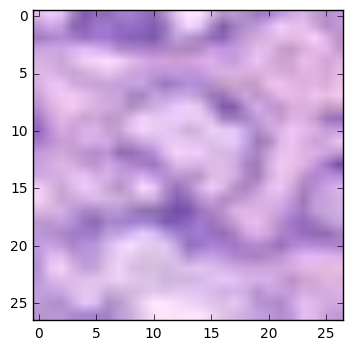

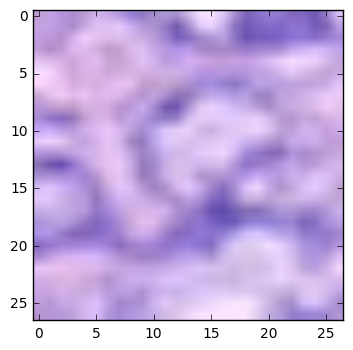

In [279]:
plt.imshow(train_patches[5])
plt.figure()
plt.imshow(sorted_train_dict['patches'][1])

print sorted_train_dict['flips'][1], sorted_train_dict['rots'][1], sorted_train_dict['deltas'][1]

#print train_patches[4,:3,:3,:]
#print sorted_train_dict['patches'][0,:3,:3,:]

In [281]:
N = sorted_train_dict['patches'].shape[0]
np.random.seed(123) # predictable shuffling for now
perm = np.random.permutation(N)

train_dict = {k : v[perm] for (k, v) in sorted_train_dict.iteritems()}

In [283]:
sess= None

In [284]:
def classifier_model(image_batch):
    with slim.arg_scope([slim.conv2d, slim.fully_connected],
                        activation_fn=tf.nn.relu,
                        weights_initializer=tf.truncated_normal_initializer(stddev=0.01),
                        biases_initializer=tf.zeros_initializer,
                        weights_regularizer=slim.l2_regularizer(0.0005),
                        biases_regularizer=None):
        with slim.arg_scope([slim.conv2d, slim.max_pool2d], padding='VALID'):
            with slim.arg_scope([slim.dropout], keep_prob=0.8):
                net = image_batch
                net = slim.conv2d(net, 36, [4, 4], scope='1_conv')
                net = slim.max_pool2d(net, [2, 2], scope='2_max_pool')
                net = slim.conv2d(net, 48, [3, 3], scope='3_conv')
                net = slim.max_pool2d(net, [2, 2], scope='4_max_pool')
                net = slim.flatten(net, scope='4_flatten')
                net = slim.fully_connected(net, 512, scope='5_fc')
                net = slim.dropout(net, scope='5_dropout')
                net = slim.fully_connected(net, 512, scope='6_fc')
                net = slim.dropout(net, scope='6_dropout')
                net = slim.fully_connected(net, 4, activation_fn=None, scope='7_fc')
                return net    

In [285]:
if sess is not None:
    sess.close()
tf.reset_default_graph()
sess = tf.InteractiveSession()
patch_tensor = tf.placeholder(dtype='float32', shape=(None, 27, 27, 3))
label_tensor = tf.placeholder(dtype='int32', shape=(None, 4))
with tf.variable_scope("classifier"):
    with slim.arg_scope([slim.dropout], is_training=True):
        prediction_logits = classifier_model(patch_tensor)
with tf.variable_scope("classifier", reuse=True):
    with slim.arg_scope([slim.dropout], is_training=False):
        inference_prediction_logits = classifier_model(patch_tensor)

In [286]:
def get_training_op(prediction_logits, labels):
    loss = slim.losses.softmax_cross_entropy(prediction_logits, labels)
    total_loss = slim.losses.get_total_loss()
    optimizer = tf.train.MomentumOptimizer(momentum=0.9, learning_rate=5e-4)#learning_rate=0.01)
    #optimizer = tf.train.AdamOptimizer()
    train_op = slim.learning.create_train_op(total_loss, optimizer)
    return (train_op, loss)

In [287]:
(train_op, loss) = get_training_op(prediction_logits, label_tensor)

In [288]:
predictions = slim.softmax(prediction_logits)
inference_predictions = slim.softmax(inference_prediction_logits)

In [289]:
predictions.get_shape(), inference_predictions.get_shape(), label_tensor.get_shape()

(TensorShape([Dimension(None), Dimension(4)]),
 TensorShape([Dimension(None), Dimension(4)]),
 TensorShape([Dimension(None), Dimension(4)]))

In [290]:
def get_accuracy(predictions, labels):
    p = tf.argmax(predictions, dimension=1)
    l = tf.argmax(labels, dimension=1)
    correct = tf.equal(p, l)
    #print correct.get_shape()
    return tf.reduce_mean(tf.cast(correct, tf.float32))

In [291]:
def get_weighted_f1(predictions, labels):
    p = tf.argmax(predictions, dimension=1)
    l = tf.argmax(labels, dimension=1)
    f1s = []
    totals = []
    C = labels.get_shape()[1]
    def cnt(t):
        return tf.reduce_sum(tf.cast(t, tf.float32))
    def w(c, msg, t):
        return tf.Print(t, [t], message=(msg + "_" + str(c) + ":"))
        #return t
    for c in xrange(C):
        c = np.array([c], dtype='int64')
        true_positives = w(c, "true_positive", cnt(tf.logical_and(tf.equal(c, p), tf.equal(c, l))))
        #false_positives = w(c, "false_positive", cnt(tf.logical_and(tf.equal(c, p), tf.not_equal(c, l))))
        positive_labels = w(c, "positive_labels", cnt(tf.equal(c, l)))
        positive_predictions = w(c, "positive_predictions", cnt(tf.equal(c, p)))
        recall = w(c, "recall", tf.div(true_positives, positive_labels))
        precision = w(c, "precision", tf.div(true_positives, positive_predictions))
        f1 = w(c, "f1", tf.div(2*tf.mul(precision, recall),
                               tf.add(precision, recall)))
        f1s.append(f1)
        totals.append(positive_labels)
    weights = w(0, "weights", tf.div(tf.pack(totals), tf.reduce_sum(tf.pack(totals))))
    f1_avg = w(0, "f1_avg", tf.reduce_sum(tf.mul(weights, tf.pack(f1s))))
    return f1_avg

In [292]:
def get_confusion(predictions, labels):
    C = labels.get_shape()[1]
    p_hot = tf.transpose(tf.one_hot(tf.argmax(predictions, dimension=1), depth=C, dtype=tf.int32))
    l_hot = tf.transpose(tf.one_hot(tf.argmax(labels, dimension=1), depth=C, dtype=tf.int32)) # not really necessary, other than the transpose
    # Results is CxCxbatch_size, and results[i,j,k] is one iff for example k, the model predicted j and the right answer is i
    results = tf.mul(p_hot, l_hot[:,tf.newaxis,:])
    # Sum along the batch dimension to get the confusion matrix
    return tf.reduce_sum(results, reduction_indices=2)

In [293]:
dropout_accuracy = get_accuracy(predictions, label_tensor)
accuracy = get_accuracy(inference_predictions, label_tensor)
f1 = get_weighted_f1(inference_predictions, label_tensor)
confusion = get_confusion(inference_predictions, label_tensor)

In [311]:
def train_loop(sess, patch_tensor, label_tensor, train_patches, train_labels, test_patches, test_labels, train_op, softmax_loss, epochs, batch_size, predictions, dropout_accuracy, accuracy, f1, confusion, reset=True):
    tr_loss = []
    tst_loss = []
    N = train_patches.shape[0]
    assert train_labels.shape[0] == N
    if reset:
        sess.run(tf.initialize_all_variables())
    for e in xrange(epochs):
        for i in xrange(0, N, batch_size):
            [_, loss, p] = sess.run([train_op, softmax_loss, predictions], feed_dict={
                    patch_tensor:train_patches[i:i+batch_size],
                    label_tensor:train_labels[i:i+batch_size],
                })
            step = i / batch_size
            if step % 25 == 0:
                [test_loss, dacc, acc, f] = sess.run([softmax_loss, dropout_accuracy, accuracy, f1], feed_dict={
                    patch_tensor:test_patches,
                    label_tensor:test_labels,
                })
                print "Epoch %d, step %d, training loss %f, test_loss %f, accuracy = %f/%f, f1 = %f" % (e, step, loss, test_loss, dacc, acc, f)
                tr_loss.append(loss)
                tst_loss.append(test_loss)
        [test_loss, dacc, acc, f, conf] = sess.run([softmax_loss, dropout_accuracy, accuracy, f1, confusion], feed_dict={
            patch_tensor:test_patches,
            label_tensor:test_labels,
        })
        print "End of epoch %d, training loss %f, test_loss %f, accuracy = %f/%f, f1 = %f" % (e, loss, test_loss, dacc, acc, f)
        print "Confusion matrix:"
        print conf
    return (tr_loss, tst_loss)

In [295]:
# no augmentation
#tr_loss, tst_loss = train_loop(sess, patch_tensor, label_tensor, train_patches, train_labels, test_patches, test_labels, train_op, loss, 20, 100, predictions, dropout_accuracy, accuracy, f1, confusion)
# with augmentation
tr_loss, tst_loss = train_loop(sess, patch_tensor, label_tensor, train_dict['patches'], train_dict['labels'], test_patches, test_labels, train_op, loss, 10, 100, predictions, dropout_accuracy, accuracy, f1, confusion)

Epoch 0, step 0, training loss 1.385972, test_loss 1.385075, accuracy = 0.299779/0.285293, f1 = nan
Epoch 0, step 25, training loss 1.385546, test_loss 1.384749, accuracy = 0.303707/0.256813, f1 = nan
Epoch 0, step 50, training loss 1.385060, test_loss 1.384792, accuracy = 0.279646/0.263197, f1 = nan
Epoch 0, step 75, training loss 1.386350, test_loss 1.384438, accuracy = 0.286275/0.266634, f1 = nan
Epoch 0, step 100, training loss 1.386402, test_loss 1.384992, accuracy = 0.273263/0.262706, f1 = nan
Epoch 0, step 125, training loss 1.385279, test_loss 1.385345, accuracy = 0.278419/0.262460, f1 = nan
Epoch 0, step 150, training loss 1.386474, test_loss 1.385108, accuracy = 0.278173/0.262460, f1 = nan
Epoch 0, step 175, training loss 1.386583, test_loss 1.385894, accuracy = 0.283329/0.262460, f1 = nan
Epoch 0, step 200, training loss 1.384832, test_loss 1.385964, accuracy = 0.280383/0.262460, f1 = nan
Epoch 0, step 225, training loss 1.385841, test_loss 1.385684, accuracy = 0.270808/0.26

In [312]:
# Try another 10 epochs
tr_loss2, tst_loss2 = train_loop(sess, patch_tensor, label_tensor, train_dict['patches'], train_dict['labels'], test_patches, test_labels, train_op, loss, 10, 100, predictions, dropout_accuracy, accuracy, f1, confusion, reset=False)

Epoch 0, step 0, training loss 0.928781, test_loss 0.740336, accuracy = 0.719371/0.726246, f1 = 0.730010
Epoch 0, step 25, training loss 0.738759, test_loss 0.744890, accuracy = 0.717898/0.720599, f1 = 0.727124
Epoch 0, step 50, training loss 0.760501, test_loss 0.790295, accuracy = 0.693837/0.690400, f1 = 0.696823
Epoch 0, step 75, training loss 0.797289, test_loss 0.821563, accuracy = 0.671495/0.673214, f1 = 0.689692
Epoch 0, step 100, training loss 0.729637, test_loss 0.764322, accuracy = 0.701203/0.712497, f1 = 0.714252
Epoch 0, step 125, training loss 0.868844, test_loss 0.704825, accuracy = 0.733121/0.737049, f1 = 0.729109
Epoch 0, step 150, training loss 0.984896, test_loss 0.739363, accuracy = 0.711760/0.716671, f1 = 0.714522
Epoch 0, step 175, training loss 0.798900, test_loss 0.757382, accuracy = 0.710042/0.720354, f1 = 0.727601
Epoch 0, step 200, training loss 0.948437, test_loss 0.739112, accuracy = 0.718880/0.725755, f1 = 0.726923
Epoch 0, step 225, training loss 0.850388,

In [313]:
# Save the model
saver = tf.train.Saver()
save_path = saver.save(sess, "classification_models/v3_augmentation/model.ckpt")
print "Saved to:", save_path

Saved to: classification_models/v3_augmentation/model.ckpt


In [ ]:
# Restore the model
saver = tf.train.Saver()
saver.restore(sess, "classification_models/v1/model.ckpt")

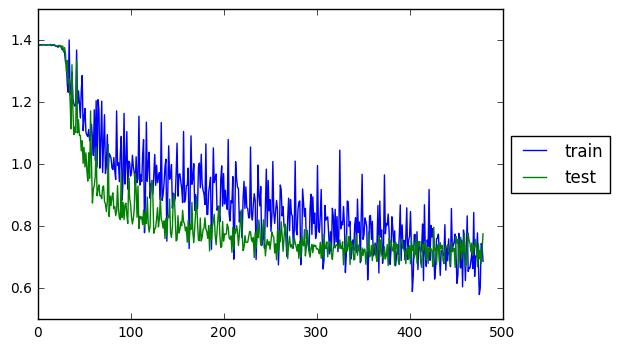

In [314]:
x = xrange(len(tr_loss + tr_loss2))
plt.plot(x, tr_loss + tr_loss2, label='train')
plt.plot(x, tst_loss + tst_loss2, label='test')
plt.legend(loc='center left', bbox_to_anchor=(1,0.5))

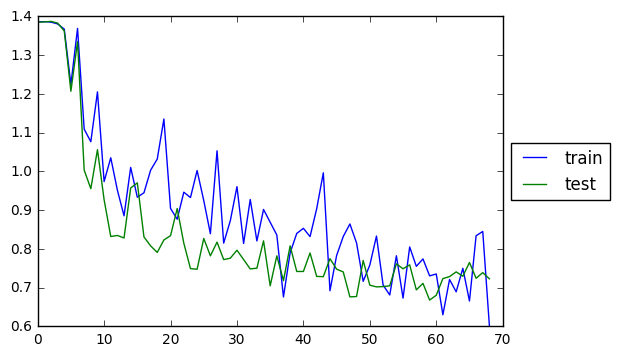

In [315]:
@interact(s=widgets.IntSlider(min=0,max=23,step=1,value=0))
def f(s):
    x = xrange(len((tr_loss + tr_loss2)[s::7]))
    plt.plot(x, (tr_loss + tr_loss2)[s::7], label='train')
    plt.plot(x, (tst_loss + tst_loss2)[s::7], label='test')
    plt.legend(loc='center left', bbox_to_anchor=(1,0.5))

In [300]:
def get_NEP_prediction(sess, patch_tensor, prediction_tensor, img, centre, H, W, d):
    assert H%2==1
    assert W%2==1
    halfH = (W-1)/2
    halfW = (H-1)/2
    (imgH, imgW, _) = img.shape
    (x, y) = centre

    # Helper function to check for out of bounds
    def inbounds(dx, dy):
        return (x + dx - halfW >= 0 and
                x + dx + halfW < imgW and
                y + dy - halfH >= 0 and
                y + dy + halfH < imgH)
    
    # Iterate over each neighbour position
    patches = []
    for dx in range(-d, d+1):
        for dy in range(-d, d+1):
            if dx**2 + dy**2 <= d**2 and inbounds(dx, dy):
                patches.append(img[y+dy-halfH:y+dy+halfW+1,x+dx-halfW:x+dx+halfW+1,:])
                #print (dx, dy, math.sqrt(dx**2+dy**2))
    assert len(patches) > 0
    patches = np.stack(patches)
    #print patches.shape

    # Run prediction
    predictions = sess.run(prediction_tensor, feed_dict={
            patch_tensor: patches,
        })
    
    # Get average prediction
    #print predictions.shape
    average_predictions = np.mean(predictions, axis=0)
    #print average_predictions.shape
    return (average_predictions, patches)

In [316]:
example = 3
(avg_pred, patches_used) = get_NEP_prediction(sess,
                                               patch_tensor,
                                               inference_predictions,
                                               i[test_img_ids[example]],
                                               test_centres[example],
                                               27,
                                               27,
                                               4)
print avg_pred
print test_labels[example]

[ 0.90826339  0.03643493  0.04092112  0.01438036]
[1 0 0 0]


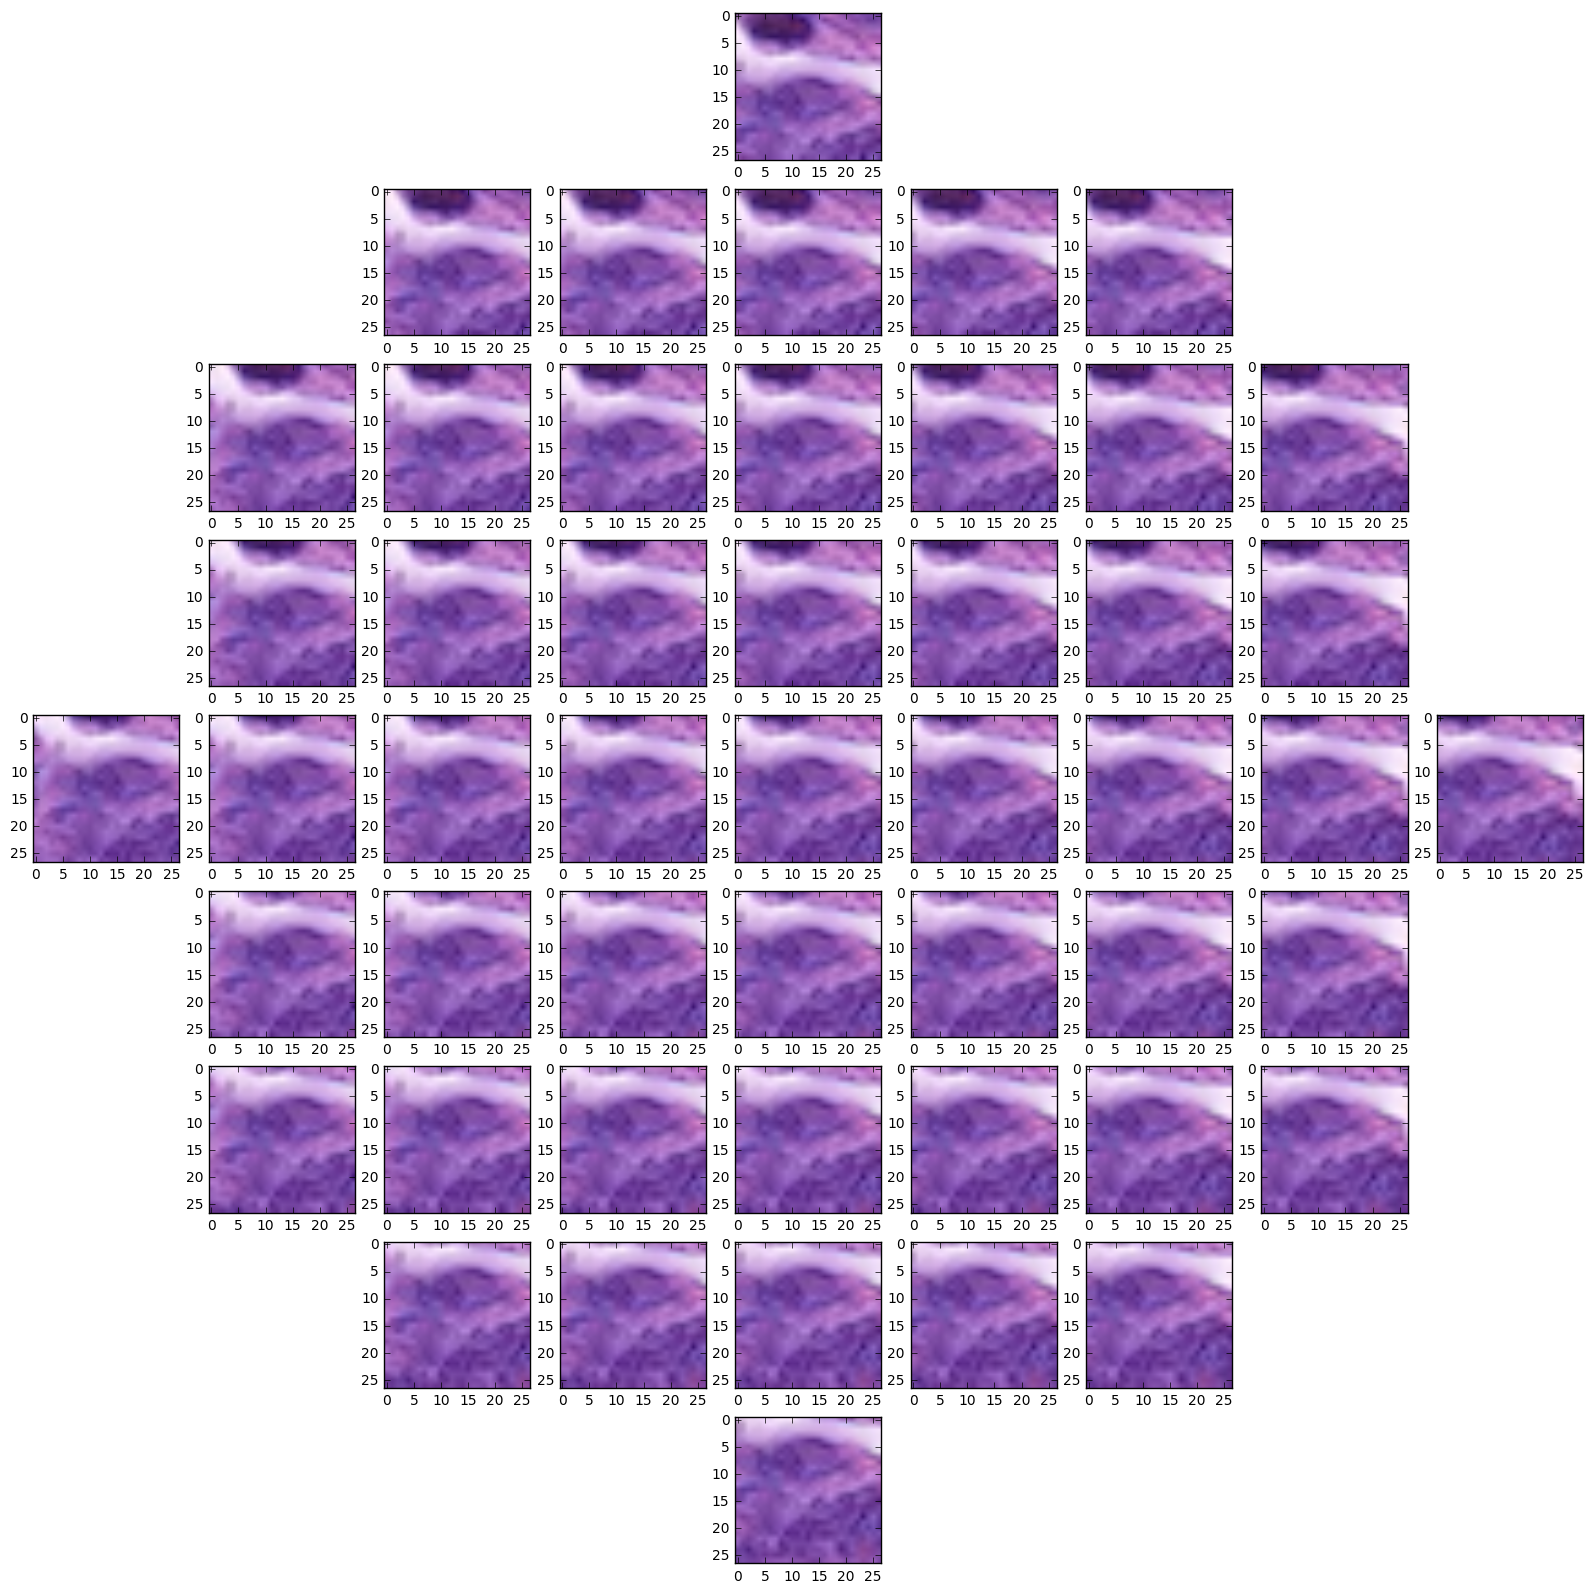

In [317]:
ii = 0
plt.figure(figsize=(20,20))
for dx in range(-4, 5):
    for dy in range(-4, 5):
        if dx**2 + dy**2 <= 4**2:
            plt.subplot(9, 9, (dy+4)*9 + (dx+4) + 1)
            plt.imshow(patches_used[ii])
            ii += 1

In [328]:
all_nep_predictions = []
d = 4
for ii in range(len(test_patches)):
    (avg_pred, _) = get_NEP_prediction(sess,
                                       patch_tensor,
                                       inference_predictions,
                                       i[test_img_ids[ii]],
                                       test_centres[ii],
                                       27,
                                       27,
                                       d)
    all_nep_predictions.append(avg_pred)
all_nep_predictions = np.stack(all_nep_predictions)

In [329]:
print sess.run([accuracy, f1, confusion], feed_dict={
        inference_predictions: all_nep_predictions,
        label_tensor: test_labels,
    })

[0.76651114, 0.76562738, array([[1130,  180,   71,   12],
       [ 110,  803,  111,   45],
       [  42,  125, 1023,   63],
       [  24,   77,   91,  166]], dtype=int32)]


Results for f1-score for various d:

0 = .75110334
1 = .75696123
2 = .76257628
3 = .76513195
4 = .76562738

# Misc

In [74]:
a = tf.constant([[1, 2, 4, 3],
                 [4, 5, 2, 1],
                 [4, 5, 2, 9],
                 [40, 5, 2, 1],
                 [4, 55, 2, 1],])
b = tf.constant([[4, 5, 2, 1],
                 [1, 2, 4, 3],
                 [4, 5, 2, 9],
                 [40, 5, 2, 1],
                 [4, 55, 2, 1],])
a_hot = tf.transpose(tf.one_hot(tf.argmax(a, dimension=1), depth=4))
b_hot = tf.transpose(tf.one_hot(tf.argmax(b, dimension=1), depth=4))
tf.transpose(tf.mul(a_hot, b_hot[:,tf.newaxis,:])).eval()

array([[[ 0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.],
        [ 0.,  1.,  0.,  0.],
        [ 0.,  0.,  0.,  0.]],

       [[ 0.,  0.,  0.,  0.],
        [ 0.,  0.,  1.,  0.],
        [ 0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.]],

       [[ 0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  1.]],

       [[ 1.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.]],

       [[ 0.,  0.,  0.,  0.],
        [ 0.,  1.,  0.,  0.],
        [ 0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.]]], dtype=float32)

In [70]:
tf.mul(tf.constant([0,1,0,0]), tf.constant([[1],[0],[0],[0]])).eval()

array([[0, 1, 0, 0],
       [0, 0, 0, 0],
       [0, 0, 0, 0],
       [0, 0, 0, 0]], dtype=int32)

In [20]:
a = tf.constant(1, shape=(1,2,2,1))
b = tf.constant(2, shape=(1,2,2,1))
c = tf.constant(3, shape=(1,2,2,1))
d = tf.constant(4, shape=(1,2,2,1))

In [21]:
tf.__version__

'0.10.0'

In [22]:
# From the python itertools 'recipes' section
def roundrobin(*iterables):
    "roundrobin('ABC', 'D', 'EF') --> A D E B F C"
    # Recipe credited to George Sakkis
    pending = len(iterables)
    nexts = itertools.cycle(iter(it).next for it in iterables)
    while pending:
        try:
            for next in nexts:
                yield next()
        except StopIteration:
            pending -= 1
            nexts = itertools.cycle(itertools.islice(nexts, pending))

In [23]:
ab = tf.pack(list(roundrobin(tf.unpack(a, axis=1), tf.unpack(b, axis=1))), axis=1)
cd = tf.pack(list(roundrobin(tf.unpack(c, axis=1), tf.unpack(d, axis=1))), axis=1)
abcd = tf.pack(list(roundrobin(tf.unpack(ab, axis=2), tf.unpack(cd, axis=2))), axis=2)

In [25]:
for (x1, x2, x3, x4) in abcd[0,:,:,0].eval():
    print (x1,x2,x3,x4)

(1, 3, 1, 3)
(2, 4, 2, 4)
(1, 3, 1, 3)
(2, 4, 2, 4)


In [84]:
x = tf.placeholder(tf.float32, shape=(None, 4))
y = tf.placeholder(tf.int32, shape=(None, 4))
a = get_accuracy(x, y)
b = get_weighted_f1(x, y)
c = get_confusion(x, y)
print sess.run([a, b, c], feed_dict={
        x:np.array([[1,0,0,0],
                    [1,0,0,0],
                    [1,0,0,0],
                    [1,0,0,0],]),
        y:np.array([[1,0,0,0],
                    [1,0,0,0],
                    [0,0,1,0],
                    [0,0,0,1],]),
    }) 

[0.5, nan, array([[ 2.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.],
       [ 1.,  0.,  0.,  0.],
       [ 1.,  0.,  0.,  0.]], dtype=float32)]
